多因子模型：回归

In [135]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression
from utils import *

In [136]:
df_all = pd.read_csv('data/df_all.csv', dtype={'asset': str})
df_all['date'] = pd.to_datetime(df_all['date'])
df_all.drop(['Unnamed: 0', 'Rmrf', 'Smb', 'Hml'], axis=1, inplace=True)
df_all_pivot = df_all.pivot(index='date', columns='asset')

In [137]:
df_all_pivot.columns

MultiIndex([('open', '000001'),
            ('open', '000002'),
            ('open', '000009'),
            ('open', '000012'),
            ('open', '000021'),
            ('open', '000039'),
            ('open', '000046'),
            ('open', '000059'),
            ('open', '000060'),
            ('open', '000061'),
            ...
            (  'bm', '601919'),
            (  'bm', '601928'),
            (  'bm', '601933'),
            (  'bm', '601939'),
            (  'bm', '601958'),
            (  'bm', '601988'),
            (  'bm', '601989'),
            (  'bm', '601991'),
            (  'bm', '601992'),
            (  'bm', '601998')],
           names=[None, 'asset'], length=7514)

In [138]:
print("已经有的因子：")
df_all.columns

已经有的因子：


Index(['asset', 'date', 'open', 'close', 'high', 'low', 'volume', 'amount',
       'vwap', 'pctChg', 'turnover', 'benchmark_open', 'benchmark_close',
       'benchmark_high', 'benchmark_low', 'benchmark_vol', 'roe', 'roa', 'cvd',
       'epq', 'emq', 'sgq', 'alaq', 'pmq', 'cta', 'size', 'rf', 'bm'],
      dtype='object')

In [139]:
returns = pd.read_csv('data/returns.csv', index_col=0)
returns.index = pd.to_datetime(returns.index)
dates = returns.index
dates

DatetimeIndex(['2013-05-02', '2013-05-03', '2013-05-06', '2013-05-07',
               '2013-05-08', '2013-05-09', '2013-05-10', '2013-05-13',
               '2013-05-14', '2013-05-15',
               ...
               '2022-04-18', '2022-04-19', '2022-04-20', '2022-04-21',
               '2022-04-22', '2022-04-25', '2022-04-26', '2022-04-27',
               '2022-04-28', '2022-04-29'],
              dtype='datetime64[ns]', name='date', length=2191, freq=None)

In [140]:
returns.columns
assets = returns.columns

In [141]:
# 从因子数据中读取因子
alphaset = 'ourAlphas'
subset = '20130430'

from MyBacktrader import get_alpha_list

alpha_names = get_alpha_list(f'alphas/{alphaset}/{subset}')
# alpha_names = ['alpha_financial_health']

for alpha_name in alpha_names:
    alpha = pd.read_csv('alphas/{}/{}/{}.csv'.format(alphaset, subset, alpha_name))
    
    # 从因子数据中读取因子
    alpha = alpha.set_index('date')
    alpha.index = pd.to_datetime(alpha.index)

    # 给 alpha 添加双重索引
    alpha.columns = pd.MultiIndex.from_product([[f'{alpha_name}'], alpha.columns], names=['', 'asset'])

    # 合并 alpha 到 df_all_pivot
    df_all_pivot = pd.concat([df_all_pivot, alpha], axis=1)

    # print(df_combined)
    # 合并到df_all_pivot
    # df_all_pivot = pd.concat([df_all_pivot, alpha], axis=1)

In [142]:
print("已经有的因子：")
print(df_all_pivot.columns.get_level_values(0).unique())

已经有的因子：
Index(['open', 'close', 'high', 'low', 'volume', 'amount', 'vwap', 'pctChg',
       'turnover', 'benchmark_open', 'benchmark_close', 'benchmark_high',
       'benchmark_low', 'benchmark_vol', 'roe', 'roa', 'cvd', 'epq', 'emq',
       'sgq', 'alaq', 'pmq', 'cta', 'size', 'rf', 'bm', 'alpha001',
       'alpha_ALAQ', 'alpha_bm', 'alpha_CTA', 'alpha_CVD', 'alpha_EMQ',
       'alpha_EPQ', 'alpha_Fama_French', 'alpha_financial_health',
       'alpha_High_Low', 'alpha_Hml', 'alpha_liquidity', 'alpha_market_alpha',
       'alpha_momentum', 'alpha_momentum_60', 'alpha_multi', 'alpha_PMQ',
       'alpha_PMQ_momentum', 'alpha_Price_VWAP', 'alpha_reversal',
       'alpha_Rmrf', 'alpha_ROA_momentum', 'alpha_ROE', 'alpha_ROE_ROA',
       'alpha_rsi', 'alpha_sentiment', 'alpha_SGQ', 'alpha_SGQ_volatility',
       'alpha_size', 'alpha_Smb', 'alpha_trade_density', 'alpha_turnover',
       'alpha_turnover_10', 'alpha_turnover_month', 'alpha_Volume_Close',
       'alpha_vol_skew'],
      dtype='o

In [143]:
Y = returns - df_all_pivot['rf'].values
# print(Y.head())

X = df_all_pivot.drop(['rf', 'alpha_Fama_French', 'open', 'close', 'high', 'low', 'volume', 'amount', 'pctChg', 'cta', 'roe', 'alpha_Hml', 'alpha_Smb', 'alpha_Rmrf','vwap', 'pctChg',
       'turnover', 'benchmark_open', 'benchmark_close', 'benchmark_high',
       'benchmark_low', 'benchmark_vol', 'roe', 'roa', 'cvd', 'epq', 'emq',
       'sgq', 'alaq', 'pmq', 'cta', 'size', 'rf', 'bm'], axis=1, level=0)

X.columns.get_level_values(0).unique()

Index(['alpha001', 'alpha_ALAQ', 'alpha_bm', 'alpha_CTA', 'alpha_CVD',
       'alpha_EMQ', 'alpha_EPQ', 'alpha_financial_health', 'alpha_High_Low',
       'alpha_liquidity', 'alpha_market_alpha', 'alpha_momentum',
       'alpha_momentum_60', 'alpha_multi', 'alpha_PMQ', 'alpha_PMQ_momentum',
       'alpha_Price_VWAP', 'alpha_reversal', 'alpha_ROA_momentum', 'alpha_ROE',
       'alpha_ROE_ROA', 'alpha_rsi', 'alpha_sentiment', 'alpha_SGQ',
       'alpha_SGQ_volatility', 'alpha_size', 'alpha_trade_density',
       'alpha_turnover', 'alpha_turnover_10', 'alpha_turnover_month',
       'alpha_Volume_Close', 'alpha_vol_skew'],
      dtype='object')

In [149]:
def mse(y_true, y_pred):
    if(y_true is None or y_pred is None):
        return 0
    
    return np.mean((y_true - y_pred)**2)

In [145]:
import statsmodels.api as sm

# 提取资产列表（多重索引的第二层）
assets = X.columns.get_level_values(1).unique()
# assets = ['601939']

# 创建 DataFrame 存储回归结果
regression_betas = pd.DataFrame(columns=['Asset'] + list(X.columns.get_level_values(0).unique()) + ['Intercept'])
expected_columns = ['Asset'] + list(X.columns.get_level_values(0).unique()) + ['Intercept']

regression_models = {}
regression_preds = pd.DataFrame(index=dates, columns=assets)

total_mse_regression = 0

# 对每个资产进行回归
for asset in assets:
    # print("asset: ", asset)
    # 提取该资产对应的 Y 和 X
    y = Y[asset].dropna()
    x = X.xs(asset, axis=1, level=1).reindex(y.index)  # 确保时间对齐

    # 添加常数项
    x = sm.add_constant(x)

    # 找出缺失的列
    missing_columns = [col for col in expected_columns if col not in x.columns and col != 'Asset']
    
    # 手动补充缺失列
    for col in missing_columns:
        x[col] = 0

    # 确保列顺序一致
    x = x[expected_columns[1:]]  # 排除 'Asset'，其余列按 expected_columns 的顺序排列

    # 回归分析
    model = sm.OLS(y, x).fit()
    
    pred = model.predict(x)
    regression_preds[asset] = pred

    # 计算 MSE
    mse_val = mse(y, pred)
    total_mse_regression += mse_val

    # 记录回归结果
    result = [asset] + list(model.params.reindex(expected_columns[1:]).fillna(0).values)
    
    # 保存回归模型
    regression_models[asset] = model

    # 检查 result 的长度和 regression_betas 的列数
    # print("result 的长度:", len(result))
    # print("regression_betas 的列数:", len(regression_betas.columns))

    regression_betas.loc[len(regression_betas)] = result
    

# 设置列名
regression_betas.columns = ['Asset'] + list(X.columns.get_level_values(0).unique()) + ['Intercept']

print("MSE:")
print(total_mse_regression)

MSE:
95.40798196127368


In [ ]:
import pandas as pd
from xgboost import XGBRegressor
import numpy as np

# 获取资产列表
asset_list = X.columns.get_level_values(1).unique()

# 存储每个资产的 XGBoost 模型
xgb_models = {}
xgb_preds = pd.DataFrame(index=dates, columns=asset_list)

total_mse_xgb = 0

# 对每个资产进行回归
for asset_id in asset_list:
    # 提取资产对应的 Y 和 X
    target_y = Y[asset_id].dropna()
    feature_x = X.xs(asset_id, axis=1, level=1).reindex(target_y.index)

    # 初始化 XGBoost 回归模型
    xgb_regressor = XGBRegressor(
        n_estimators=100,  # 决策树数量
        learning_rate=0.1,  # 学习率
        max_depth=3,       # 最大树深度
        random_state=42    # 随机种子
    )

    # 训练 XGBoost 模型
    xgb_regressor.fit(feature_x, target_y)

    # 保存模型
    xgb_models[asset_id] = xgb_regressor
    
    # 预测
    xgb_pred = pd.DataFrame(xgb_regressor.predict(feature_x), index=feature_x.index, columns=[asset_id])
    
    # 保存预测结果
    xgb_preds[asset_id] = xgb_pred
    
    
    

MSE:
nan


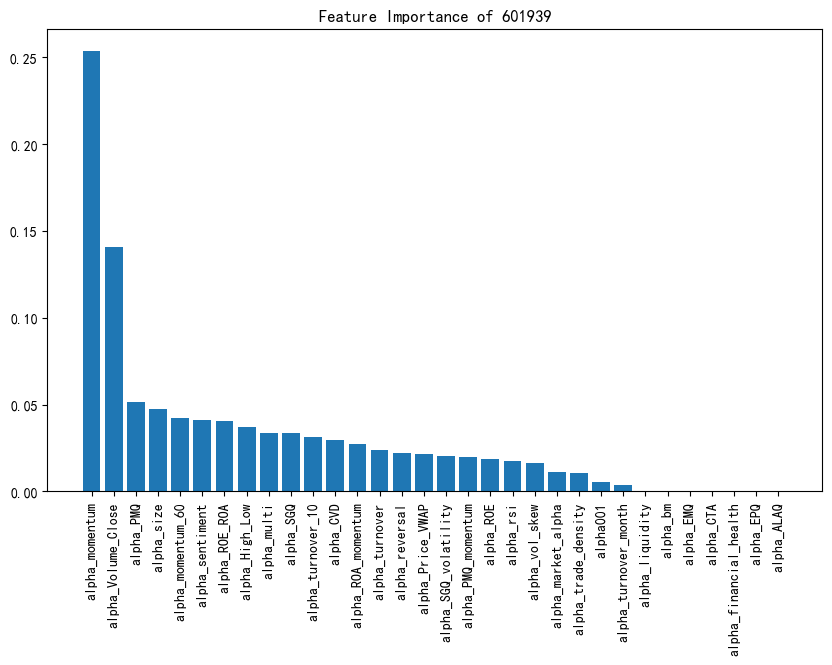

In [161]:
import matplotlib.pyplot as plt
from xgboost import plot_importance
import matplotlib

# 让图像可以在notebook中展示
%matplotlib inline

# 选择一个特定的资产，比如 '601939'
asset_id = '601939'

# 提取该资产对应的 XGBoost 模型
xgb_model = xgb_models[asset_id]

summary = pd.DataFrame(xgb_model.feature_importances_, index=X.columns.get_level_values(0).unique(), columns=['Importance'])
summary = summary.sort_values(by='Importance', ascending=False)

# 画图
plt.figure(figsize=(10, 6))
plt.bar(summary.index, summary['Importance'])
plt.xticks(rotation=90)
plt.title(f'Feature Importance of {asset_id}')
plt.show()


In [164]:
# 画散点图
def plot_y_and_pred(y, pred, asset_id):
    plt.figure(figsize=(10, 6))
    plt.scatter(y.index, y, label='True', s = 5)
    plt.scatter(pred.index, pred, label='Predicted', s = 5)
    plt.title(f'True and Predicted Returns of {asset_id}')
    plt.legend()
    plt.show()

e:\Anaconda\envs\py310\lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from font(s) SimHei.
  fig.canvas.print_figure(bytes_io, **kw)


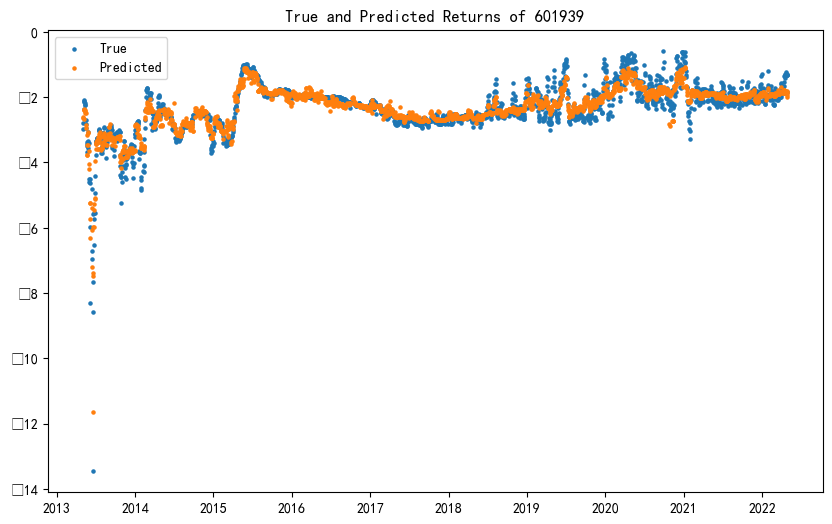

In [165]:
asset_id = '601939'

# 提取该资产对应的 Y 和 pred
y = Y[asset_id].dropna()
pred = xgb_preds[asset_id]

plot_y_and_pred(y, pred, asset_id)